In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, QTable, join

import thejoker as tj
import pymc as pm
import corner
import arviz as az
import astropy.units as u
from astropy.time import Time

In [2]:
apogee_gold  = Table.read("../../lithium/cosmic/apogee_goldsample.fits")
apw_binaries = Table.read('../../lithium/cosmic/apw_binaries.fits')


In [6]:
apogee_dr16_visit = Table.read('../files/apogee_dr16_allVisit-r12-l33.fits')


In [7]:
apogee_dr16 = Table.read('../../lithium/data/allStarLite-r12-l33.fits')
apogee_dr16 = apogee_dr16[(apogee_dr16['TEFF']>0) & (apogee_dr16['LOGG']>-9000.) ]



In [8]:
apogee_rg = apogee_dr16[(apogee_dr16['TEFF']<=5730) & (apogee_dr16['TEFF']>=3000) & 
                        (apogee_dr16['LOGG']<=3.2) & (apogee_dr16['LOGG']>=-1) & 
                        (apogee_dr16['NVISITS']>=4) &
                        (apogee_dr16['WASH_DDO51_GIANT_FLAG']==1)
                       ]
len(apogee_rg)

7876

In [9]:
len(apogee_dr16_visit)

1778792

In [10]:
mask = np.isin(apogee_dr16_visit['APOGEE_ID'], apogee_rg['APOGEE_ID'])

apogee_dr16_visit = apogee_dr16_visit[mask]

In [11]:
len(apogee_dr16_visit)

63642

In [12]:
apogee_cut  = apogee_rg.copy()
apogee_cut2 = apogee_dr16_visit.copy()
print(len(apogee_cut))
print(len(apogee_cut2))
apogee_cut  = apogee_cut[(apogee_cut['STARFLAG'] != 3) & (apogee_cut['STARFLAG'] != 16) & (apogee_cut['ASPCAPFLAG'] != 16) & 
                        (apogee_cut['ASPCAPFLAG'] != 17) & (apogee_cut['ASPCAPFLAG'] != 18) & (apogee_cut['ASPCAPFLAG'] != 26) & 
                        (apogee_cut['ASPCAPFLAG'] != 30)]
apogee_cut2 = apogee_cut2[(apogee_cut2['STARFLAG']!=3) & (apogee_cut2['STARFLAG']!=9) & (apogee_cut2['STARFLAG']!=12) & (apogee_cut2['STARFLAG']!= 13)& (apogee_cut2['STARFLAG']!= 16)]

merged = join(apogee_cut, apogee_cut2, keys='APOGEE_ID')
print(len(apogee_cut))
print(len(apogee_cut2))
len(merged)


7876
63642
7747
62577


69379

In [ ]:
# apogee_dr16_visit.keys()



In [28]:
def pipeline():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))
    
    new_df = {'APOGEE_ID':[],
              'semi_amp': [],
              'logg': []
             }
    
    for i,star in enumerate(unique_apogee_id):
        #print(i, star)
        
        dtemp = merged[merged['APOGEE_ID'] == star]
        rv_vals = dtemp['VHELIO'].value
        err     = dtemp['VRELERR'].value
        time = dtemp['JD']
        time = Time(time, format="jd", scale="tcb")
        mask = (err<10.)

        time, rv_vals, err = time[mask], rv_vals[mask], err[mask]
        time   = time.mjd
        semi_k = (max(rv_vals) - min(rv_vals))*0.5
        log_g  = dtemp['LOGG'][0]
#         print(log_g, semi_k)
        new_df['APOGEE_ID'].append(star)
        new_df['semi_amp'].append(semi_k)
        new_df['logg'].append(log_g)
    return new_df  
        
#         data = [time, rv_vals, err]
#         data = np.array(data)
#         np.max()
#         np.save('apogee_reference_samples/%s.npy'%star, data )
        
#         joker_samples = run_joker(data, Pi=1, Pf=3000)
#         save_dir = 'apogee_reference_samples/%s.hdf5'%(star)
#         joker_samples[0].write(save_dir, overwrite=True)
        #print('\n')
      
new_df = pipeline()
        

# of unique RGs: 7336


In [29]:
def func1(logg):
    a, b = -0.60, 3.31
    log_v = a*logg+b
    return 10.**log_v
    
def func2(logg):
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+3.5*siga
    b = b+3.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
def func3(logg):
    siga, sigb = -0.04, -0.10
    a, b = -0.60, 3.31
    a = a+3.5*siga
    b = b+3.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
def func_2sigma(logg):
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+2*siga
    b = b+2*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
def func4(logg):
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+1.5*siga
    b = b+1.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
    

In [40]:
type(new_df_2['logg'][0])

numpy.float32

(2621, 7336, 0.3572791712104689)

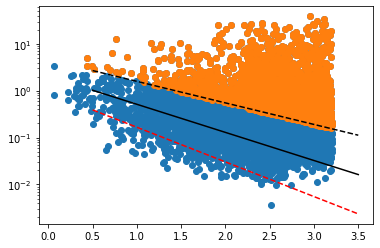

In [50]:
new_df_2 = pd.DataFrame(new_df)
new_df_2['exp_amp'] = func2(new_df_2['logg'])/1000.# func2()/1000.
xvals = np.linspace(0.5,3.5,1000)
# p
# new_df['logg']
plt.scatter(new_df_2['logg'], new_df_2['semi_amp'])
mask = (new_df_2['semi_amp'] >= new_df_2['exp_amp'])
plt.scatter(new_df_2[mask]['logg'], new_df_2[mask]['semi_amp'])


plt.plot(xvals, func1(xvals)/1000., c='k')
plt.plot(xvals, func2(xvals)/1000., c='k',ls='dashed')
plt.plot(xvals, func3(xvals)/1000., c='r',ls='dashed')
plt.yscale('log')
len(new_df_2[mask]),len(new_df_2),len(new_df_2[mask])/len(new_df_2)

# of unique RGs: 7336
0 2M16041667-1117345
# of joker samples returned second round: 256


1 2M13240628-0150392
# of joker samples returned second round: 256


2 2M17184836+5855357
# of joker samples returned second round: 256


3 2M21322584+1244382
# of joker samples returned second round: 40


4 2M00370650+8507344
# of joker samples returned second round: 9


5 2M16150970+5125524
# of joker samples returned second round: 256


6 2M16035269-1101180
# of joker samples returned second round: 30


7 2M14003989+3355077
# of joker samples returned second round: 1


8 2M15125673+0117582
# of joker samples returned second round: 2


9 2M12441943-0646559
# of joker samples returned second round: 256


10 2M12475844-0740324
# of joker samples returned second round: 7


11 2M15051278+2116105
# of joker samples returned second round: 256


12 2M16305269-0059169
# of joker samples returned second round: 256


13 2M11450465-1423511
# of joker samples returned second round: 256


14 2M13080380+5730

<ipython-input-16-9de178558e2f>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))




21 2M17214096+4246147
# of joker samples returned second round: 256


22 2M14280484-0629500
# of joker samples returned second round: 256


23 2M17012769+5924431
# of joker samples returned second round: 256


24 2M07364852+2204473
# of joker samples returned second round: 256


25 2M14592841+3716540
# of joker samples returned second round: 256


26 2M17021415+1121169
# of joker samples returned second round: 256


27 2M03161346+0204540
# of joker samples returned second round: 256


28 2M13011686-0318049
# of joker samples returned second round: 256


29 2M14593188+2235560
# of joker samples returned second round: 1


30 2M17002509+0931293
# of joker samples returned second round: 256


31 2M14332892+0829386
# of joker samples returned second round: 256


32 2M10100560+0319434
# of joker samples returned second round: 256


33 2M16012724+2931395
# of joker samples returned second round: 80


34 2M16545040+1139589
# of joker samples returned second round: 256


35 2M13094479+7252396

KeyboardInterrupt: 

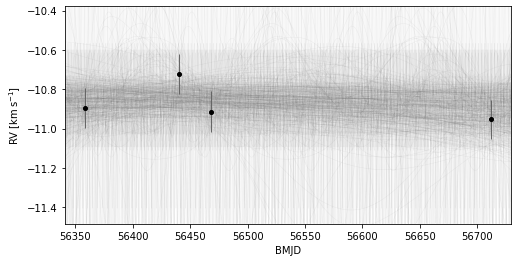

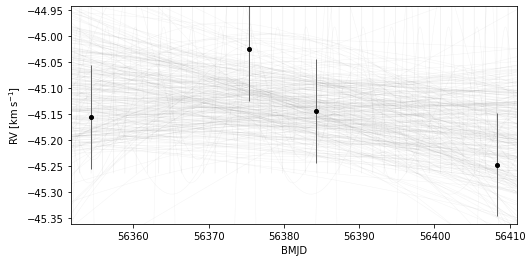

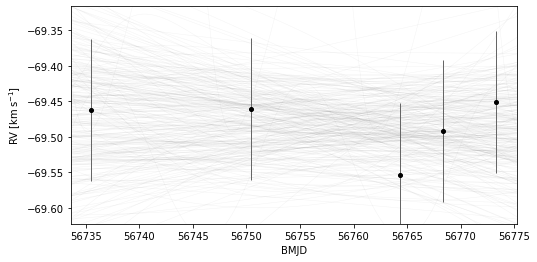

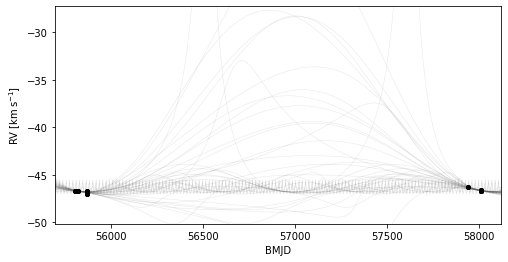

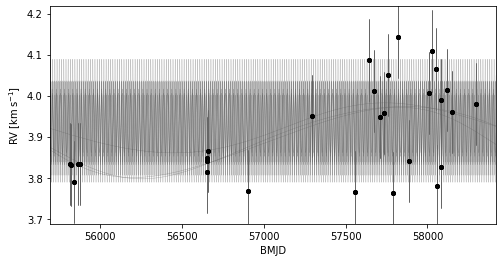

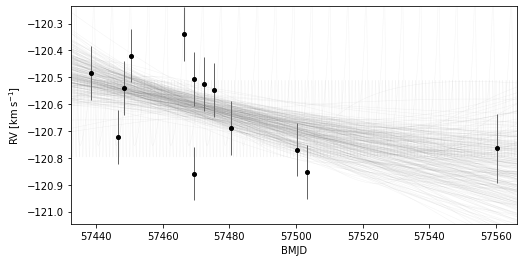

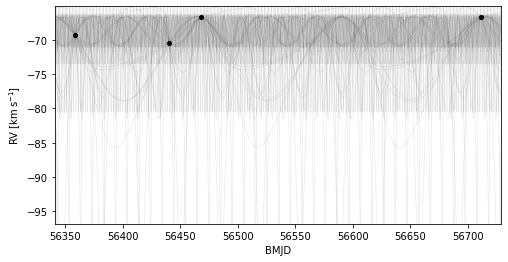

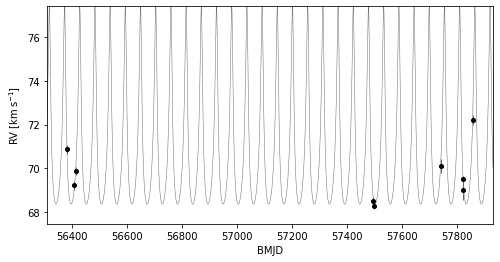

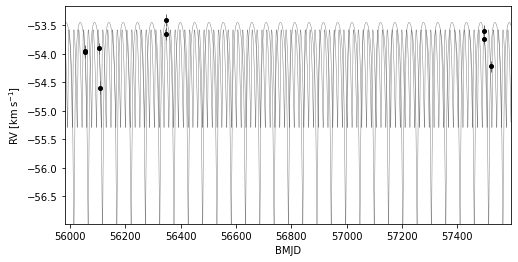

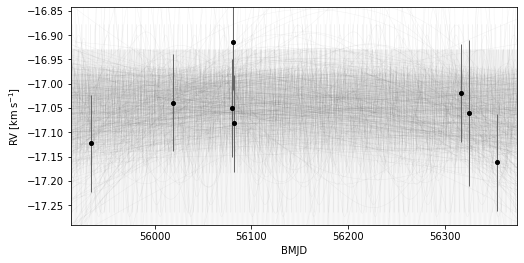

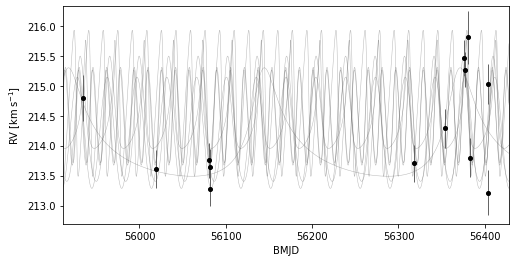

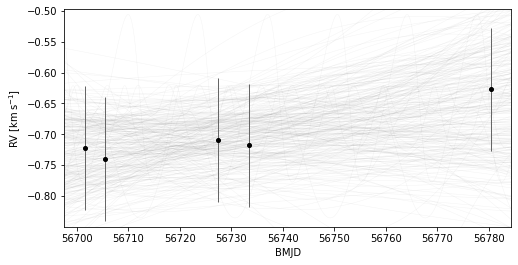

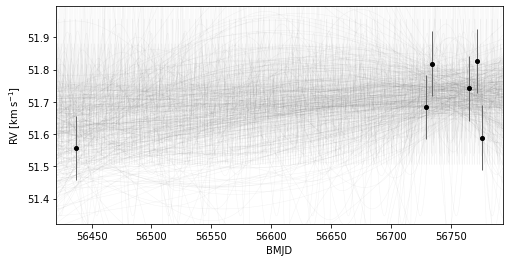

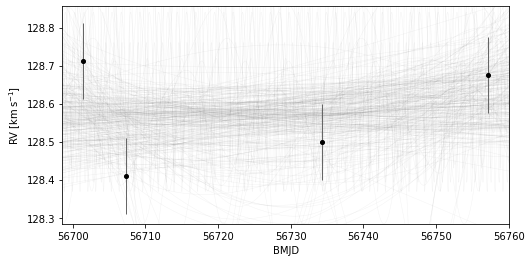

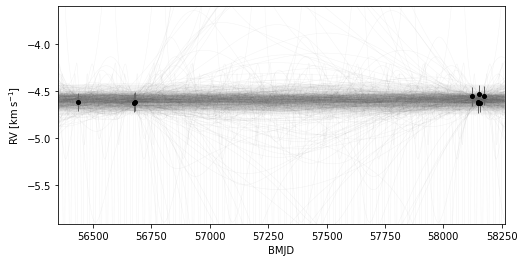

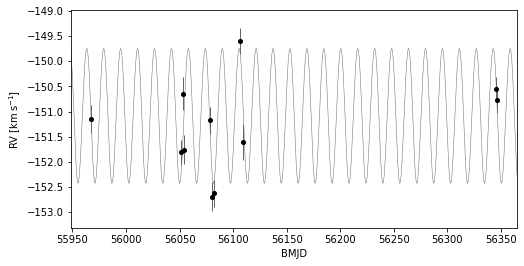

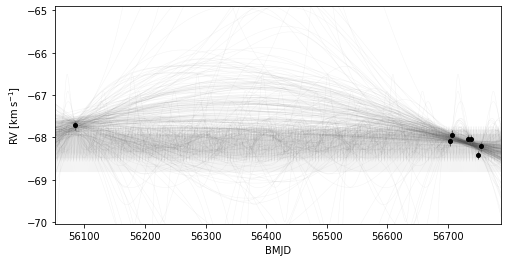

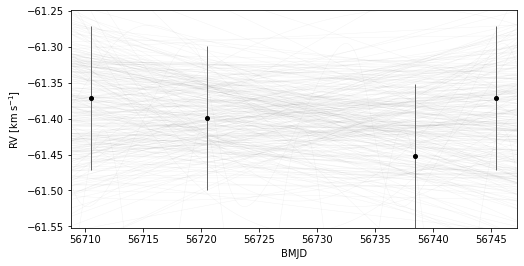

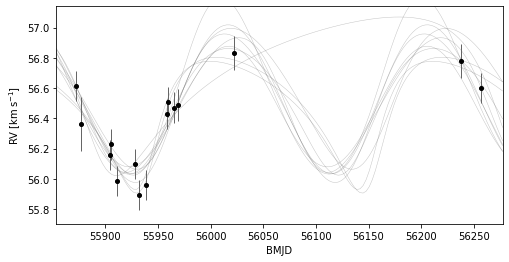

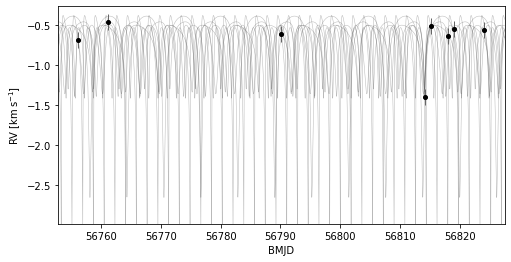

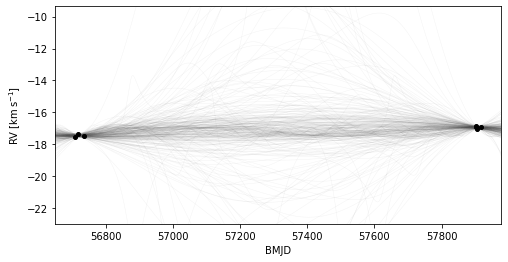

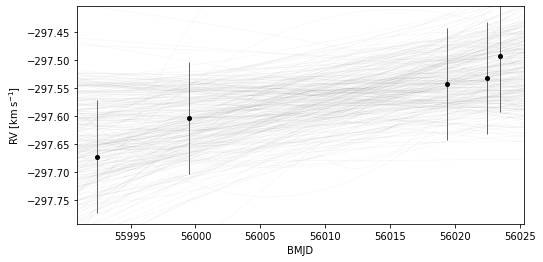

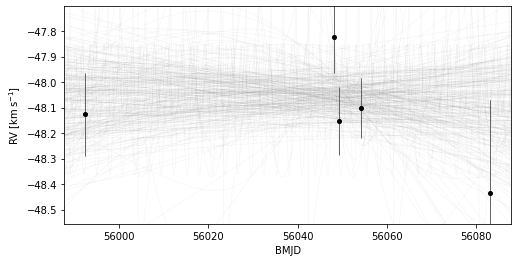

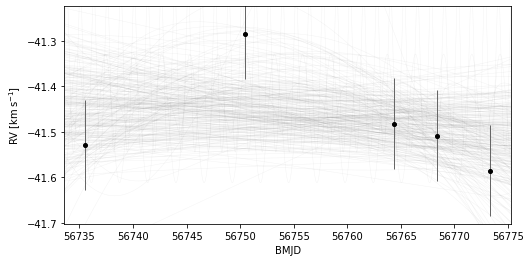

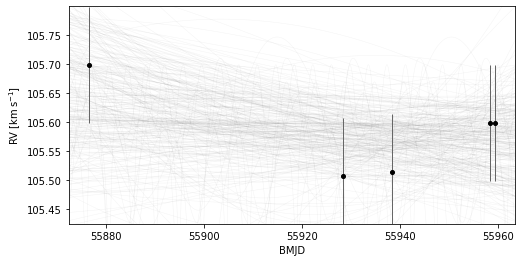

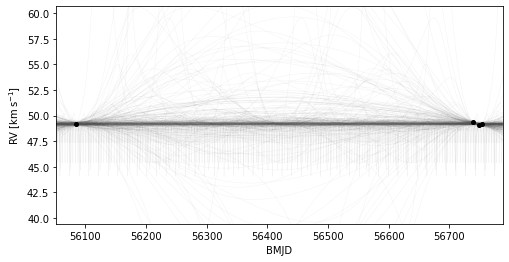

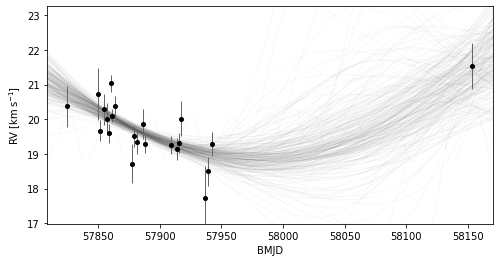

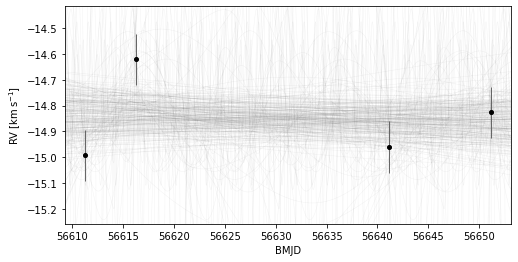

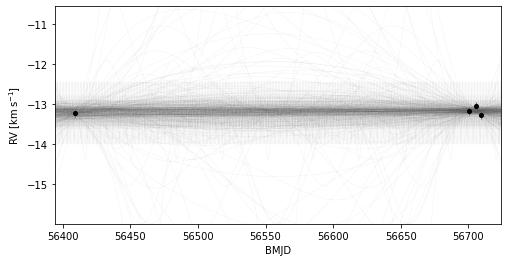

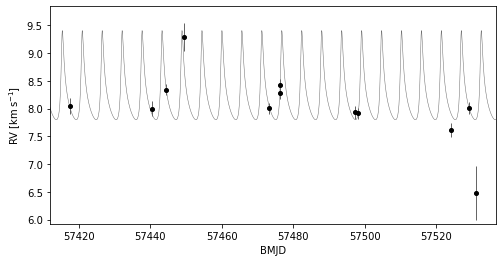

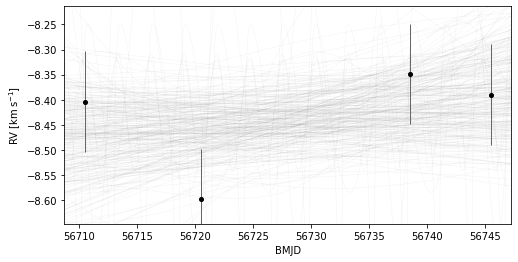

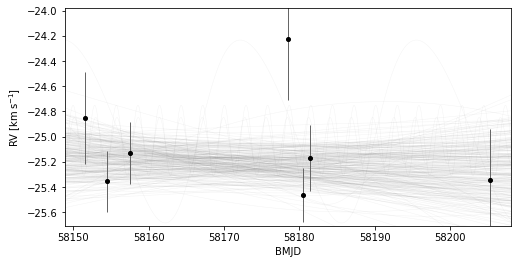

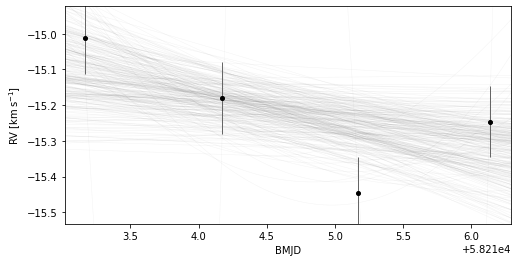

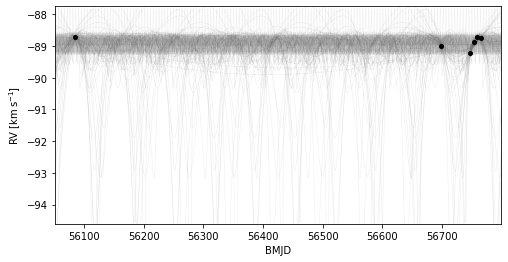

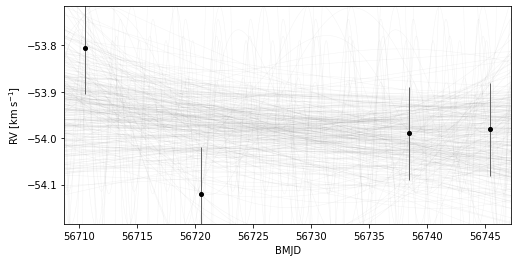

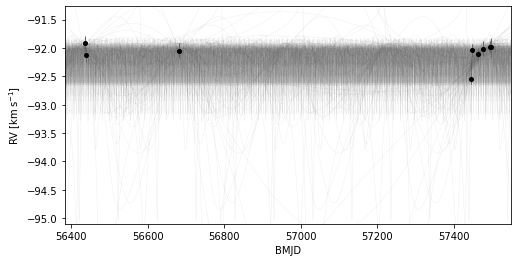

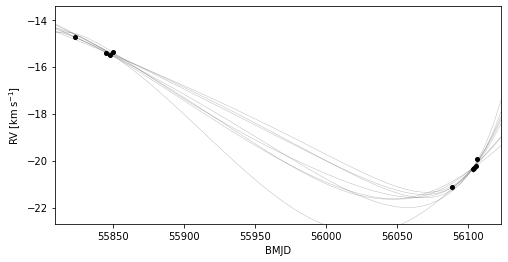

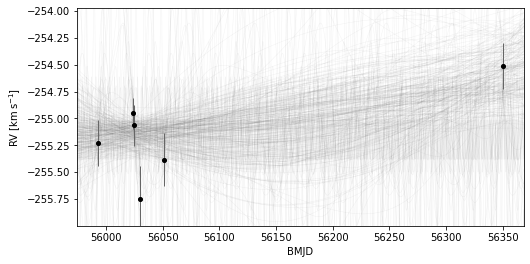

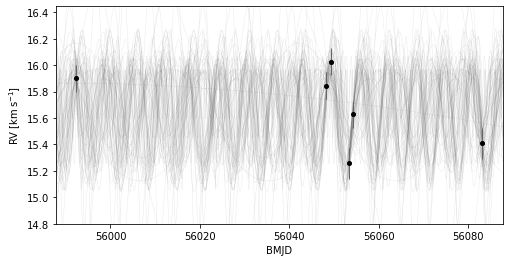

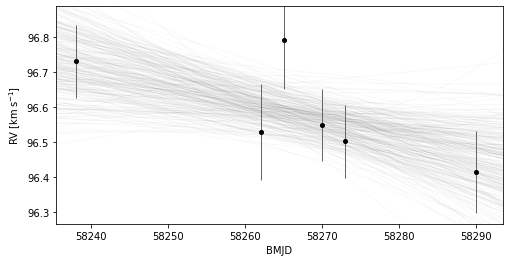

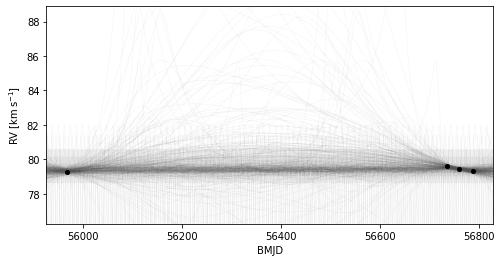

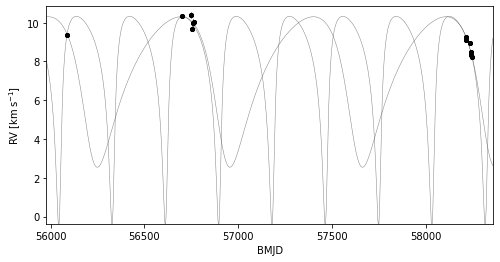

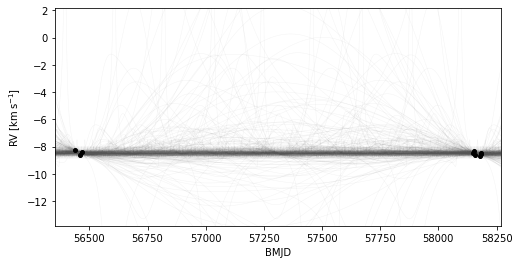

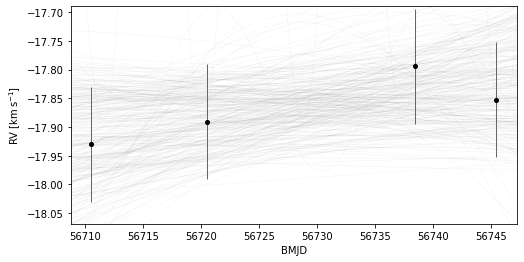

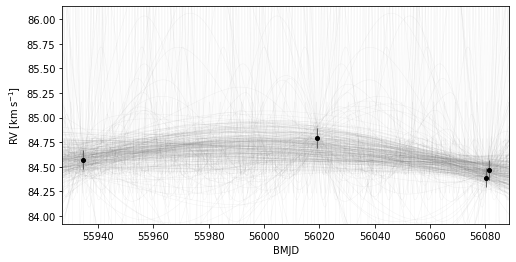

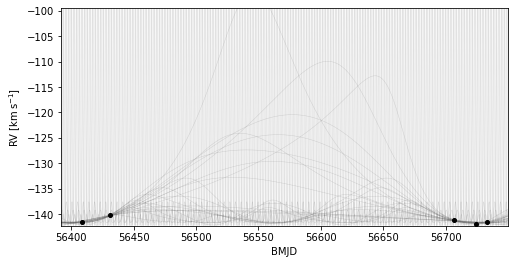

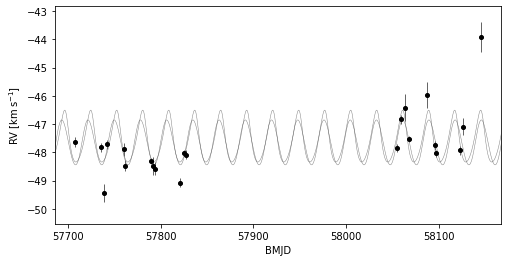

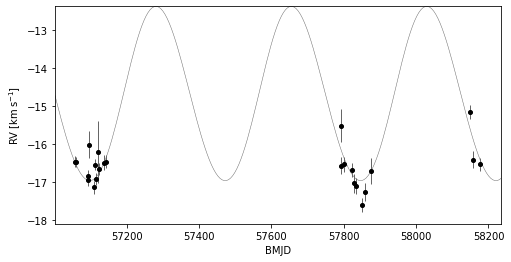

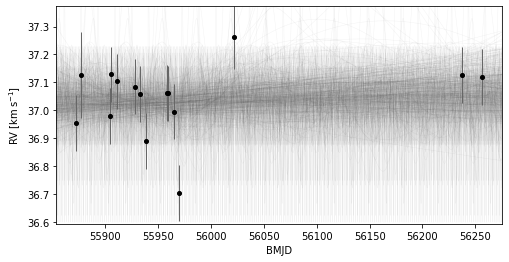

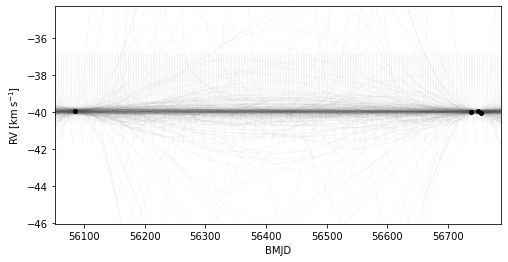

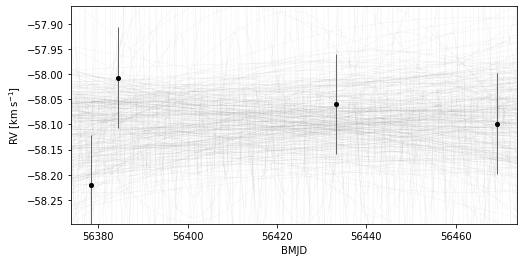

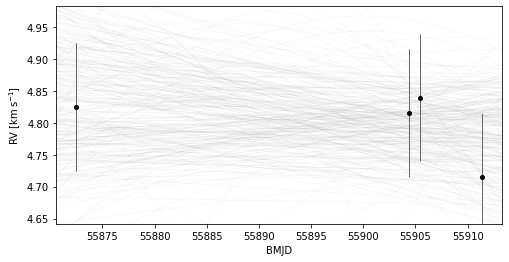

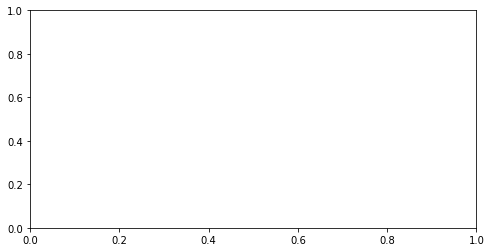

In [16]:
def run_joker(data,Pi,Pf,K0=20, max_posterior=256, error=0.1,prior_size=50_000):#,save=False,MCMC=False):
    time, rv, err = data[0], data[1], data[2]
    err            = np.array(err)
    #print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    err[(err<0.10)] = 0.10
    
    data           = Table()
    data['bmjd']   = time
    data['rv']     = rv
    data['rv_err'] = err

    #print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    t = Time(data["bmjd"], format="mjd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        prior = tj.JokerPrior.default(
                P_min = Pi * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = Pf * u.day,
                sigma_K0 = K0 * u.km / u.s,
                sigma_v=100*u.km/u.s,            
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    
    joker = tj.TheJoker(prior, rng=rnd)


    #print('running joker for posterior samples...')
    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=max_posterior,
                                           return_all_logprobs=True)
    print('# of joker samples returned second round:',len(joker_samples[0]))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    _ = tj.plot_rv_curves(
            joker_samples[0],
            data=data,
            ax=ax,
        )
    return joker_samples
    

In [ ]:

def pipeline():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))

    for i,star in enumerate(unique_apogee_id[326+52:]):
        print(i, star)
        
        dtemp = merged[merged['APOGEE_ID'] == star]
        rv_vals = dtemp['VHELIO'].value
        err     = dtemp['VRELERR'].value
        time = dtemp['JD']
        time = Time(time, format="jd", scale="tcb")
        mask = (err<10.)

        time, rv_vals, err = time[mask], rv_vals[mask], err[mask]
        time = time.mjd
        data = [time, rv_vals, err]
        data = np.array(data)
        np.save('apogee_reference_samples/%s.npy'%star, data )
        
        joker_samples = run_joker(data, Pi=1, Pf=3000)
        save_dir = 'apogee_reference_samples/%s.hdf5'%(star)
        joker_samples[0].write(save_dir, overwrite=True)
        print('\n')
        
pipeline()
        

In [ ]:
ss

In [ ]:
# 2M16073621+2252268.hdf5

# def load(name):
#         samples = JokerSamples.from_hdf5(results_f[star['APOGEE_ID']], 
#                                      poly_trend=poly_trend)
        

In [ ]:
# merge = join(apogee_dr16_visit, apogee_rg, keys='APOGEE_ID')
# VHELIO
# PERSIST_LOW
# apogee_dr16_visit[apogee_dr16_visit['APOGEE_ID']==apogee_rg['APOGEE_ID'][0]]

In [ ]:
print(max(apogee_dr16['NVISITS']))
plt.figure()
plt.hist(apogee_dr16['NVISITS'],bins=[0,1,2,3,4,5,6,7,8,9,10,20,30,50])
plt.hist(apogee_rg['NVISITS'],bins=[0,1,2,3,4,5,6,7,8,9,10,20,30,50])
plt.show()

plt.figure()
plt.scatter(apogee_dr16['TEFF'],apogee_dr16['LOGG'])
plt.scatter(apogee_rg['TEFF'],apogee_rg['LOGG'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('teff')
plt.ylabel('logg')
plt.show()

In [ ]:
apogee_dr16['TARGFLAGS']
apogee_dr16[apogee_dr16['APOGEE_TARGET1']>=0]#apogee_dr16[['APOGEE_TARGET1','APOGEE_TARGET2']]

In [ ]:
# apogee_dr16#.keys()
len(apogee_rg)

In [ ]:
set(apogee_rg['WASH_DDO51_GIANT_FLAG'])#.keys()
